In [44]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm # color stuff
from scipy.optimize import curve_fit
%matplotlib inline

def pltDefaultPar():
    #reset default matplotlib parameters for this notebook
    plt.rcParams.update({'font.size': 20})
    plt.rcParams['lines.linewidth'] = 1
    plt.rcParams['lines.markersize'] = 6
    
def pltPrintPar():
    plt.rcParams.update({'font.size': 15})
    plt.rcParams['lines.linewidth'] = 2
    plt.rcParams['lines.markersize'] = 8

rootTP="/home/johann/Remote/imac"
rootMAC="/Users/jh"
root=rootMAC

In [3]:
def plotdataArr(dataArray,xlabel,lineArr,lineParam='',title='',linestyles='',setlog='',legendloc='upper center'):
    # color stuff: http://stackoverflow.com/questions/4971269/how-to-pick-a-new-color-for-each-plotted-line-within-a-figure-in-matplotlib
    pltPrintPar()
    colors=cm.rainbow(np.linspace(0,1,len(dataArray)))
    if linestyles=='': lslist = len(dataArray) * ['o-']
    else: lslist = linestyles
    plt.figure(figsize=(7,5))
    for i, line in enumerate(dataArray):
        ti = lineParam + str(lineArr[i])
        xs = line[:,0]
        dd0s = line[:,1]/6.
        plt.plot(xs,dd0s,lslist[i],label=ti,c=colors[i])
    plt.xlabel(r'$'+xlabel+'$')
    plt.ylabel(r'$D/D_0$')
    plt.ylim([0,1.3])
    plt.title(title)
    plt.legend(loc=legendloc, bbox_to_anchor=(0.5, 1.2),
          ncol=3)
    if setlog=='y' or setlog=="double":
        plt.yscale('log')
    if setlog=='x' or setlog=="double":
        plt.xscale('log')
    plt.show()
        

# Compare D over p for Ranb and SPSnoHI

In [4]:
def getTriggerData(triggerArr,U0=0):
    triggerNameArr = []
    a=0# This if fixed here, for no HI
    datadir= root + "/Documents/workspace-cpp"
    afrac = '%g'%(float(a)/10)
    dataArr=[]
    for trigger in triggerArr:
        if trigger == 'normal':
            typedir='/SingleParticleSimulation/sim_dataOLD/noreset/dt0.0001/t200/d0/b10/'
            MSD=''
        elif trigger == 'ranRod/nrods1':
            typedir='/SingleParticleSimulation/Release/sim_data/noreset/'+trigger+'/dt0.0005/t200/d0/b10'
            MSD='MSD'
        else:
            typedir='/RanbSPS/Release/sim_data/'+trigger+'/dt0.0005/t200'
            MSD='MSD'
        triggerNameArr.append(trigger.replace('/',''))
        folder=datadir + typedir
        data = []
        for pdir in os.listdir(folder):
            file=os.path.join(folder, pdir,'k1.000/u'+str(U0)+'/InstantValues/linear_fit_parameters'+str(MSD)+'.txt')
            if os.path.isfile(file):
                p=file.split('/p')[1].split('/k')[0] # assign value from dir to p
                p='%g'%(float(p)/10)                 # make p value p/b
                with open(file, 'r') as fitf:
                    m = (fitf.readline().split('m')[1]).split()[0]
                data.append([float(p)+a/10.,float(m)]) #the [:-1] serves to cut the linebreak '\n' from the string m.
        dataArr.append(np.array(sorted(data)))
    return dataArr, triggerNameArr

### Data with random box size $b$ and fixed cylinder positions at the edges
The particles are very mobile even when they are much bigger than the mesh size.

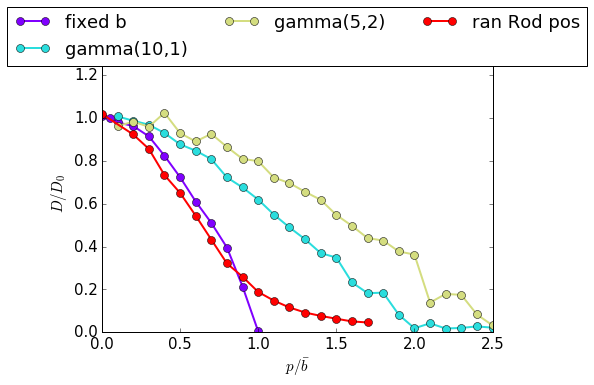

In [53]:
triggerArr = ['normal','gamma','gamma2','ranRod/nrods1']
u0data, dummy = getTriggerData(triggerArr)
triggerNameArr = ['fixed b','gamma(10,1)','gamma(5,2)','ran Rod pos']
plotdataArr(u0data,r'p/\bar{b}',lineArr=triggerNameArr)

## Evaluate Ranb+ranRod
####  Data with random $b$ and random cylinder position inside simulation box

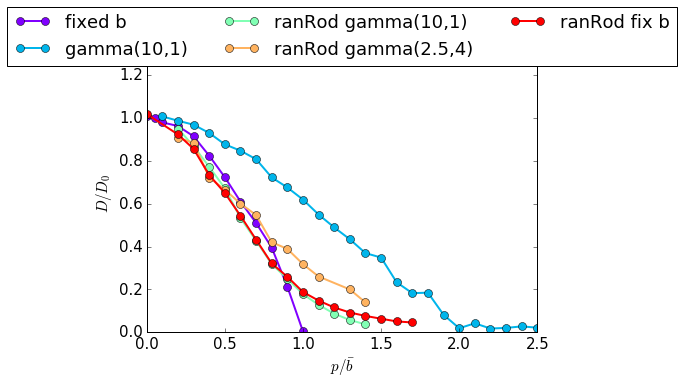

In [54]:
triggerArr = ['normal','gamma','ranRod/gamma','ranRod/gamma4','ranRod/nrods1']
u0data, dummy = getTriggerData(triggerArr)
triggerNameArr = ['fixed b','gamma(10,1)','ranRod gamma(10,1)','ranRod gamma(2.5,4)','ranRod fix b']
plotdataArr(u0data,r'p/\bar{b}',lineArr=triggerNameArr)

### Conclusion:
Looks just like the old ranRod model data with fixed $b$, i.e. we see something like a stretched exponential decrease even without HI.

## Check D over p at nonzero U_0
The range is set to $k=0.1b$.

We still see a maximum at intermediate $p$ for $U_0<0$ and practically constant diffusivities for small $p$ for $U_0>0$.
The less broad gamma(10,1) distribution has a shape

#### Gamma(10,1) distribution

In [11]:
def getDoverpVaryU0Data(u0Arr,k,trigger):
    datadir= root + "/Documents/workspace-cpp/RanbSPS/Release/sim_data/"+trigger+"/dt0.0005/t200"
    dataArr=[]
    for u0 in u0Arr:
        MSD='MSD'
        folder=datadir
        data = []
        for pdir in os.listdir(folder):
            file=os.path.join(folder, pdir,'k'+k+'/u'+str(u0)+'/InstantValues/linear_fit_parameters'+str(MSD)+'.txt')
            if os.path.isfile(file):
                p=file.split('/p')[1].split('/k')[0] # assign value from dir to p
                p='%g'%(float(p)/10)                 # make p value p/b
                with open(file, 'r') as fitf:
                    m = (fitf.readline().split('m')[1]).split()[0]
                data.append([float(p),float(m)]) #the [:-1] serves to cut the linebreak '\n' from the string m.
        dataArr.append(np.array(sorted(data)))
    return dataArr

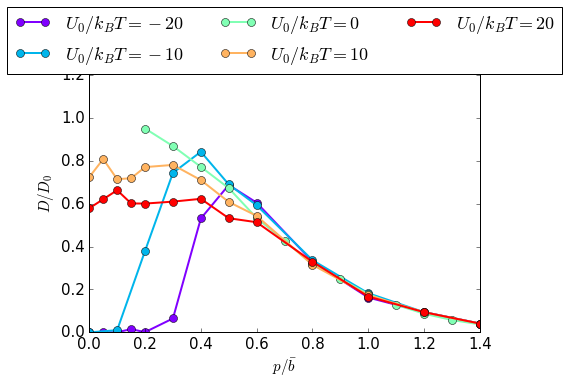

In [55]:
u0Arr = [-20,-10,0,10,20]
k='1.000'
trigger='ranRod/gamma'
lineNameArr = ['$U_0/k_BT = '+str(u)+'$' for u in u0Arr]
data = getDoverpVaryU0Data(u0Arr,k,trigger)
plotdataArr(data,r'p/\bar{b}',lineArr=lineNameArr)

#### Gamma(2.5,4) distribution:
At $p=1b$, a strong attractive interaction potential $U_0=-20k_BT$ leads to increased diffusivity

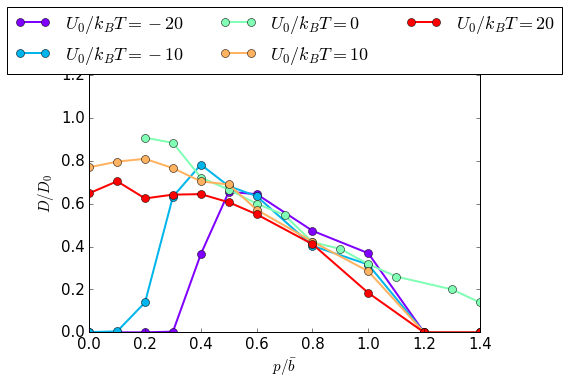

In [56]:
u0Arr = [-20,-10,0,10,20]
k='1.000'
trigger='ranRod/gamma4'
lineNameArr = ['$U_0/k_BT = '+str(u)+'$' for u in u0Arr]
data = getDoverpVaryU0Data(u0Arr,k,trigger)
plotdataArr(data,r'p/\bar{b}',lineArr=lineNameArr)

### D over U for p=0

In [36]:
def getDoverUdata(kArr,p,trigger,dt="0.0005"):
    datadir= root + "/Documents/workspace-cpp/RanbSPS/Release/sim_data/"
    dataArr=[]
    triggerNameArr = []
    for k in kArr:
        MSD='MSD'
        triggerNameArr.append(trigger.replace('/',''))
        folder=datadir +trigger+'/dt'+str(dt)+'/t200/p'+str(p)+'/k'+str(k)+'/'
        data = []
        for udir in os.listdir(folder):
            file=os.path.join(folder, udir,'InstantValues/linear_fit_parametersMSD.txt')
            if os.path.isfile(file):
                u=file.split('/u')[1].split('/I')[0] # assign value from dir to 
                with open(file, 'r') as fitf:
                    m = (fitf.readline().split('m')[1]).split()[0]
                data.append([float(u),float(m)]) #the [:-1] serves to cut the linebreak '\n' from the string m.
        dataArr.append(np.array(sorted(data)))
    return dataArr

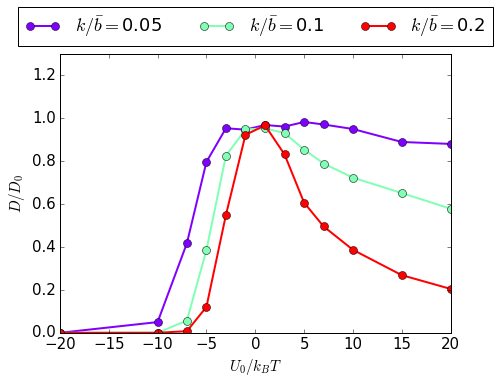

In [59]:
trigger ='ranRod/gamma'
p=0
kArr=['0.500','1.000','2.000']
krelArr=[float(k)/10. for k in kArr]
a=0# This if fixed here, for no HI
ksdata=getDoverUdata(kArr,p,trigger)
plotdataArr(ksdata,r'U_0/k_B T',lineArr=krelArr,lineParam=r'$k/ \bar{b} =$')

### D over U in combination with old cubic periodic data

In [48]:
p=0
ks=['0.500','1.000','2.000']
a=0# This if fixed here, for no HI
datadir= root + "/Documents/workspace-cpp/SingleParticleSimulation/sim_dataOLD/noreset/"
dataArr=[]
for k in ks:
    MSD='MSD'
    triggerNameArr.append(trigger.replace('/',''))
    folder=datadir +'/dt0.0001/t200/d0/b10/p'+str(p)+'/k'+str(k)+'/'
    data = []
    for udir in os.listdir(folder):
        file=os.path.join(folder, udir,'InstantValues/linear_fit_parameters.txt')
        if os.path.isfile(file):
            u=file.split('/u')[1].split('/I')[0] # assign value from dir to 
            with open(file, 'r') as fitf:
                m = (fitf.readline().split('m')[1]).split()[0]
            data.append([float(u),float(m)]) #the [:-1] serves to cut the linebreak '\n' from the string m.
    dataArr.append(np.array(sorted(data)))
ksdataOld = (dataArr)

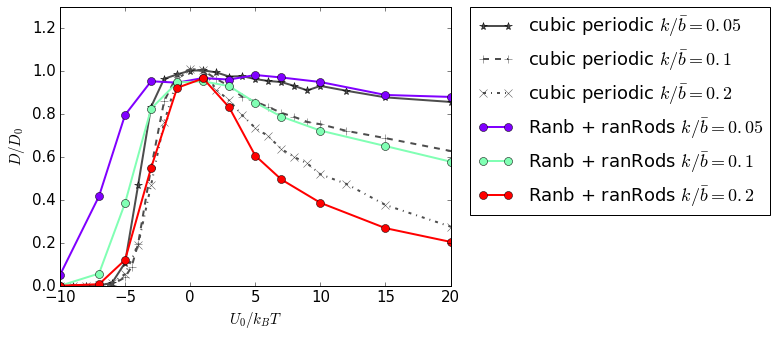

In [61]:
#plotdataArr(ksdata,,lineArr=ks,lineParam='$k$')
ksrel=[float(k)/10. for k in ks]
ksdata=getDoverUdata(kArr,p,trigger)
combinaksData =ksdata + ksdataOld
pltPrintPar()
colors=cm.rainbow(np.linspace(0,1,len(ksdata)))
plt.figure(figsize=(7,5))
lslist= ['*-','+--','x-.']
for i, line in enumerate(ksdataOld):
    ti = r'cubic periodic $k/ \bar{b} =' + str(ksrel[i]) +'$'
    xs = line[:,0]
    dd0s = line[:,1]/6.
    plt.plot(xs,dd0s,lslist[i],label=ti,c='0.3') # '0.75' is shade of grey
lslist=3 * ['o-'] 
for i, line in enumerate(ksdata):
    ti = r'Ranb + ranRods $k/ \bar{b} =' + str(ksrel[i]) +'$'
    xs = line[:,0]
    dd0s = line[:,1]/6.
    plt.plot(xs,dd0s,lslist[i],label=ti,c=colors[i])
plt.xlabel(r'$U_0/k_B T$')
plt.ylabel(r'$D/D_0$')
plt.ylim([0,1.3])
plt.xlim([-10,20])
#plt.legend(loc=2, bbox_to_anchor=(0.5, 1.2), ncol=3, fancybox=True, shadow=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### D over k for p=0

In [42]:
def getDoverkdata(uArr,p,trigger,dt="0.0005"):
    datadir= root + "/Documents/workspace-cpp/RanbSPS/Release/sim_data/"
    dataArr=[]
    triggerNameArr = []
    for u in uArr:
        MSD='MSD'
        triggerNameArr.append(trigger.replace('/',''))
        folder=datadir +trigger+'/dt'+str(dt)+'/t200/p'+str(p)+'/'
        data = []
        for udir in os.listdir(folder):
            file=os.path.join(folder, udir,'u'+str(u)+'/InstantValues/linear_fit_parametersMSD.txt')
            if os.path.isfile(file):
                k=file.split('/k')[1].split('/u')[0] # assign value from dir to k
                krel = float(k)/10.
                with open(file, 'r') as fitf:
                    m = (fitf.readline().split('m')[1]).split()[0]
                data.append([float(krel),float(m)]) #the [:-1] serves to cut the linebreak '\n' from the string m.
        dataArr.append(np.array(sorted(data)))
    return dataArr

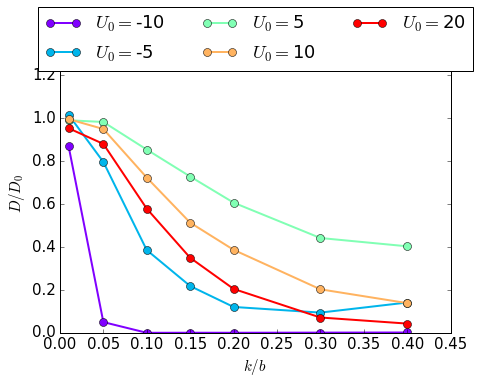

In [43]:
trigger ='ranRod/gamma'
p=0
uArr=['-10','-5','5','10','20']
a=0# This if fixed here, for no HI
ksdata=getDoverkdata(uArr,p,trigger)
plotdataArr(ksdata,r'k/b',lineArr=uArr,lineParam='$U_0 =$')

### Conclusion:
Interestingly, we do not see minima in the repulsive case anymore. Or, it may be shifted to the right (probably). To simulate with larger relative interaction range $k$, I would have to use a bigger system (or just accept that there is an unknown substantial error, due to the small system size.
The minimum in the attractive cases is strongly shifted to the right.

Since the minina are shifted to the right, I would also get different parameters for the comparison with Jason.
A larger relative interaction range k, leads to a smaller $b_{fit}$ to fit the simulation data to the experimental data, which in turn leads to a smaller $U_0$ needed to fit the data.
All in all, this might lead to better agreement between Jason and our data. 

NOTE: Maybe not, considering that the repulsive case seems to have a much stronger hindrance effect here.

___________________
___________________
___________________
___________________

# Test gamma distribution
$\Gamma(\alpha,\beta)$ where $\alpha$ and $\beta$ determine the shape of the distribution.
The mean of the distribution is $\alpha\cdot \beta$.
I look at cases where $\alpha\cdot \beta = b$, where $\bar{b}$ is the mesh size. 

In particular:
$\Gamma(10,1)$, $\Gamma(5,2)$ and $\Gamma(2.5,4)$

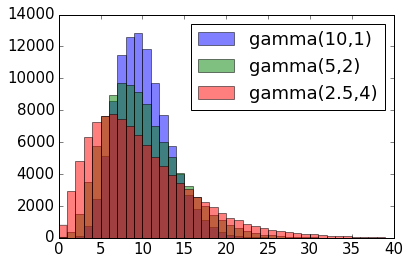

In [42]:
gammab1 = [np.random.gamma(10,1) for x in range(10**5)]
gammab2 = [np.random.gamma(5,2) for x in range(10**5)]
gammab4 = [np.random.gamma(2.5,4) for x in range(10**5)]
plt.hist(gammab1,bins=range(40),alpha=0.5,label="gamma(10,1)")
plt.hist(gammab2,bins=range(40),alpha=0.5,label="gamma(5,2)")
plt.hist(gammab4,bins=range(40),alpha=0.5,label="gamma(2.5,4)")
plt.legend()
plt.show()
bsP=[]
nzeros=0

In [ ]:
# TEST boost::gamma_distribution
gammafile = "/Users/jh/Documents/workspace-cpp/RanbSPS/Release/tmp_gamma.txt"
bs = []
with open(gammafile, 'r') as f:
    bs= f.readlines()
bs = [float(b.strip('\n')) for b in bs]
bs = np.asarray(bs)
plt.hist(bs,bins=range(40))

# Test if it is feasable to combine Ranb and ranRod
What pore size distribution do I obtain if I use the gamma distribution for the box size $b$ (Ranb) but place the rods randomly inside the simulation box (ranRod)?
In this example we use a gamma(2.5,4) distribution.

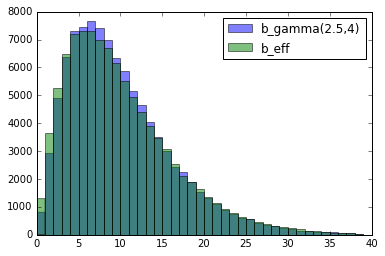

mean b_gamma = 10.0251656446
mean b_eff = 10.0251612939


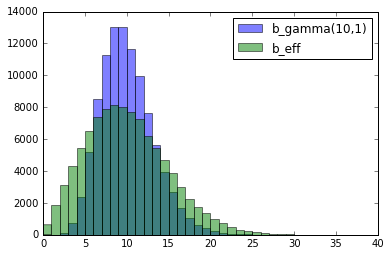

mean b_gamma = 10.0004869925
mean b_eff = 10.000466887


In [47]:
def gammab(a,b):
    return np.random.gamma(a,b)

alpha=2.5
beta=4
bs_gamma = []
bs_eff = []
b_prev = 0
rodpos_prev = 0
for i in range(100000):
    newb = gammab(alpha,beta)
    rodpos = np.random.uniform() * newb
    b_eff = b_prev - rodpos_prev + rodpos
    bs_gamma.append(newb)
    bs_eff.append(b_eff)
    b_prev = newb
    rodpos_prev = rodpos
plt.hist(bs_gamma,bins=range(40),alpha=0.5,label='b_gamma(2.5,4)')
plt.hist(bs_eff,bins=range(40),alpha=0.5,label='b_eff')
plt.legend()
plt.show()
print("mean b_gamma =",np.asarray(bs_gamma).mean())
print("mean b_eff =",np.asarray(bs_eff).mean())

alpha=10
beta=1
bs_gamma = []
bs_eff = []
b_prev = 0
rodpos_prev = 0
for i in range(100000):
    newb = gammab(alpha,beta)
    rodpos = np.random.uniform() * newb
    b_eff = b_prev - rodpos_prev + rodpos
    bs_gamma.append(newb)
    bs_eff.append(b_eff)
    b_prev = newb
    rodpos_prev = rodpos
plt.hist(bs_gamma,bins=range(40),alpha=0.5,label='b_gamma(10,1)')
plt.hist(bs_eff,bins=range(40),alpha=0.5,label='b_eff')
plt.legend()
plt.show()
print("mean b_gamma =",np.asarray(bs_gamma).mean())
print("mean b_eff =",np.asarray(bs_eff).mean())

In [25]:
def readTracerData(k,p,u,trigger='gamma'):
    tracerdata = []
    posfile = root+'/Documents/workspace-cpp/RanbSPS/Release/sim_data/'+trigger
    posfile += '/dt0.0005/t200/p'+str(p)+'/k'+str(k)+'/u'+str(u)+'/Coordinates/trajectory.txt'
    with open(posfile, 'r') as f:
        for i, line in enumerate(f):
            lines = line.split()
            tracerdata.append(lines)
    return  (np.asarray(tracerdata)).astype(float)

In [27]:
k='1.000';u=0;
p=10
tracerdat = readTracerData(k,p,u)

In [ ]:
t = tracerdat[:,0]
plt.plot(t,tracerdat[:,1],t,tracerdat[:,2],t,tracerdat[:,3])

________________
____________
____________
____________
____________
____________

# Test position shifting of ranRods
data obtained by printRodVec() function output, copied from terminal

In [64]:
data = [
    [[2,1] ,[0,-6.42889,-3.62594],[0,-2.18085,2.02793],[0,-1.65247,11.5036],[0,0,-10.0926],[0,8.56025,5.56824],[0,5.28747,19.2443],[0,11.4385,-6.5171],[0,10.3398,1.65464],[0,16.2594,18.9705]],
[[2,-1] ,[0,-1.92427,-0.0139103],[0,-6.42889,6.37406],[0,-2.18085,12.0279],[0,9.06804,-7.96832],[0,0,-0.0925607],[0,8.56025,15.5682],[0,13.3791,-4.91974],[0,11.4385,3.4829],[0,10.3398,11.6546]],
[[2,1] ,[0,-6.42889,-3.7185],[0,-2.18085,1.93537],[0,-2.94079,15.8612],[0,0,-10.1851],[0,8.56025,5.47568],[0,1.00261,18.6127],[0,11.4385,-6.60966],[0,10.3398,1.56208],[0,13.7299,19.5366]],
[[2,-1] ,[0,-1.16838,-2.05658],[0,-6.42889,6.2815],[0,-2.18085,11.9354],[0,2.25097,-4.21671],[0,0,-0.185121],[0,8.56025,15.4757],[0,12.1865,-3.36615],[0,11.4385,3.39034],[0,10.3398,11.5621]],
[[2,1] ,[0,-6.42889,-3.81106],[0,-2.18085,1.84281],[0,-6.77936,15.3303],[0,0,-10.2777],[0,8.56025,5.38311],[0,1.4761,12.8787],[0,11.4385,-6.70222],[0,10.3398,1.46952],[0,10.9434,14.6946]],
[[0,-1] ,[0,-6.42889,-3.81106],[0,-2.18085,1.84281],[0,-6.77936,15.3303],[0,0,-10.2777],[0,8.56025,5.38311],[0,1.4761,12.8787],[0,11.4385,-6.70222],[0,10.3398,1.46952],[0,10.9434,14.6946]],
[[0,1] ,[0,-6.42889,-3.81106],[0,-2.18085,1.84281],[0,-6.77936,15.3303],[0,0,-10.2777],[0,8.56025,5.38311],[0,1.4761,12.8787],[0,11.4385,-6.70222],[0,10.3398,1.46952],[0,10.9434,14.6946]],
[[0,-1] ,[0,-6.42889,-3.81106],[0,-2.18085,1.84281],[0,-6.77936,15.3303],[0,0,-10.2777],[0,8.56025,5.38311],[0,1.4761,12.8787],[0,11.4385,-6.70222],[0,10.3398,1.46952],[0,10.9434,14.6946]],
[[0,1] ,[0,-6.42889,-3.81106],[0,-2.18085,1.84281],[0,-6.77936,15.3303],[0,0,-10.2777],[0,8.56025,5.38311],[0,1.4761,12.8787],[0,11.4385,-6.70222],[0,10.3398,1.46952],[0,10.9434,14.6946]],
[[2,-1] ,[0,-1.80884,-2.2836],[0,-6.42889,6.18894],[0,-2.18085,11.8428],[0,8.82182,-5.64818],[0,0,-0.277682],[0,8.56025,15.3831],[0,11.1586,-0.190561],[0,11.4385,3.29778],[0,10.3398,11.4695]],
[[2,1] ,[0,-6.42889,-3.90362],[0,-2.18085,1.75025],[0,-1.64603,14.6611],[0,0,-10.3702],[0,8.56025,5.29055],[0,3.74962,13.6156],[0,11.4385,-6.79478],[0,10.3398,1.37696],[0,14.0902,16.2673]],
[[2,-1] ,[0,-6.64803,-8.60701],[0,-6.42889,6.09638],[0,-2.18085,11.7503],[0,0.923596,-7.83646],[0,0,-0.370243],[0,8.56025,15.2906],[0,14.7066,-2.19527],[0,11.4385,3.20522],[0,10.3398,11.377]],
[[2,1] ,[0,-6.42889,-3.99618],[0,-2.18085,1.65769],[0,-7.10147,11.2396],[0,0,-10.4628],[0,8.56025,5.19799],[0,6.36063,10.582],[0,11.4385,-6.88734],[0,10.3398,1.2844],[0,15.497,11.8813]],
[[2,-1] ,[0,-5.29668,-9.40485],[0,-6.42889,6.00382],[0,-2.18085,11.6577],[0,6.7518,-6.46347],[0,0,-0.462804],[0,8.56025,15.198],[0,14.1647,-8.70182],[0,11.4385,3.11266],[0,10.3398,11.2844]],
[[2,1] ,[0,-6.42889,-4.08874],[0,-2.18085,1.56513],[0,-7.1985,11.3448],[0,0,-10.5554],[0,8.56025,5.10543],[0,9.84541,10.4922],[0,11.4385,-6.9799],[0,10.3398,1.19184],[0,10.9116,18.8294]],
[[2,-1] ,[0,-2.62278,-6.65763],[0,-6.42889,5.91126],[0,-2.18085,11.5651],[0,7.23352,-5.59431],[0,0,-0.555364],[0,8.56025,15.1054],[0,13.4996,-0.813307],[0,11.4385,3.0201],[0,10.3398,11.1918]],
[[2,1] ,[0,-6.42889,-4.1813],[0,-2.18085,1.47257],[0,-0.0568928,34.1001],[0,0,-10.6479],[0,8.56025,5.01287],[0,2.87899,17.5698],[0,11.4385,-7.07247],[0,10.3398,1.09928],[0,13.8884,13.7852]]]

In [ ]:
axis = [x[0][0] for x in data]
exitmark = [x[0][1] for x in data]
positions = np.asarray([x[1:] for x in data])
print(positions[0])

In [ ]:
for i in range(0,5):
    ys = positions[i,:,1]
    zs = positions[i,:,2]
    plt.scatter(ys, zs)
    plt.scatter(positions[i+1,:,1], positions[i+1,:,2],c='r')
    plt.title('axis: '+str(axis[i])+'   exitmark: '+str(exitmark[i]))
    plt.xlabel('y')
    plt.ylabel('z')
    #plt.xlim([-10,20])
    #plt.ylim([-10,20])
    plt.show()